In [1]:
#Imports
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import xgboost as xgb
from PIL import Image, ImageOps

In [10]:
df = pd.read_excel("NFL Champion RawData.xlsx")
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Pass

In [11]:
data_columns = ['over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP', 'team_defense_G', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD', 'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP', 'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds', 'passing_offense_TD', 'passing_offense_TD%', 'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A', 'passing_offense_AY/A', 'passing_offense_Y/C', 'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Yds.1', 'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [6]:
correlation_matrix = data.corr()

correlation_threshold = .90

columns_to_remove = set()
print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

Columns to be Removed:
sum team L5Y cs (correlated with sum playoff games): 0.91
sum team L8Y cs (correlated with sum playoff games): 0.95
sum franchise L1Y cs (correlated with sum team L1Y cs): 0.92
sum team L5Y cs (correlated with sum team L3Y cs): 0.96
sum team L8Y cs (correlated with sum team L3Y cs): 0.93
L (correlated with W): -1.00
W-L% (correlated with W): 1.00
PD (correlated with W): 0.91
MoV (correlated with W): 0.91
OSRS (correlated with PF): 0.92
team_offense_PF (correlated with PF): 1.00
team_defense_PA (correlated with PA): 1.00
team_defense_G (correlated with team_offense_G): 1.00
passing_offense_G (correlated with team_offense_G): 1.00
team_offense_Tot Yds & TO_Y/P (correlated with team_offense_Tot Yds & TO_Yds): 0.91
team_offense_Tot Yds & TO_1stD (correlated with team_offense_Tot Yds & TO_Yds): 0.92
passing_offense_Cmp (correlated with team_offense_Tot Yds & TO_Cmp): 1.00
passing_offense_Att (correlated with team_offense_Tot Yds & TO_Att): 1.00
team_offense_Passing_1s

In [7]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'T', 'PF', 'PA', 'SoS', 'SRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_1stPy', 'team_o

## Feature Selection:
- Identificaiton Columns: 'Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season',
- Prediction Column:  'champion share',  
- Additional Features Removed:
- Feature Change Out:

Removed useless and multi-correlated features beings wins, point differential features, and ties.

### The Importance of SRS Explained:
From looking over the most stats in the correlation matrix there were many point differential stats that correlated with each other highly, so many had to be removed.
Choosing SRS was the best fit for the model. SRS is the most advanced PD stat, because it adjust for strength of schedule and when experimenting with the other PD stats,
SRS out performed them. Something to learn from this is that direct correlation (pearson correlation coefficents) are not always the correct answer.

In [12]:
features = ['sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games',
            'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 
            'SRS', 'OSRS', 'DSRS', 'SoS', '1 seed', '2 seed', '3 seed', 
            '4 seed', '5 seed', '6 seed', 'pso', 'team_offense_G', 'team_offense_Tot Yds & TO_Yds', 
            'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_Cmp', 
            'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 
            'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 
            'team_offense_Penalties_Pen', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_defense_Tot Yds & TO_Yds',
            'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD',
            'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int', 'team_defense_Passing_Att',
            'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 'team_defense_Penalties_Pen', 
            'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP', 'passing_offense_Cmp%',
            'passing_offense_Lng', 'passing_offense_AY/A', 'passing_offense_Y/C', 'passing_offense_Sk', 'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP']

num_features = len(features)

print(f"Number of features: {num_features}")

Number of features: 72


In [13]:
#best set

features = ['sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games',
            'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 
            'SRS', 'OSRS', 'DSRS', 'SoS', '1 seed', '2 seed', '3 seed', 
            '4 seed', '5 seed', '6 seed', 'pso', 'team_offense_G', 'team_offense_Tot Yds & TO_Yds', 
            'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_Cmp', 
            'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 
            'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 
            'team_offense_Penalties_Pen', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_defense_Tot Yds & TO_Yds',
            'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD',
            'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int', 'team_defense_Passing_Att',
            'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 'team_defense_Penalties_Pen', 
            'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP', 'passing_offense_Cmp%',
            'passing_offense_Lng', 'passing_offense_AY/A', 'passing_offense_Y/C', 'passing_offense_Sk', 'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP']

num_features = len(features)

print(f"Number of features: {num_features}")

Number of features: 72


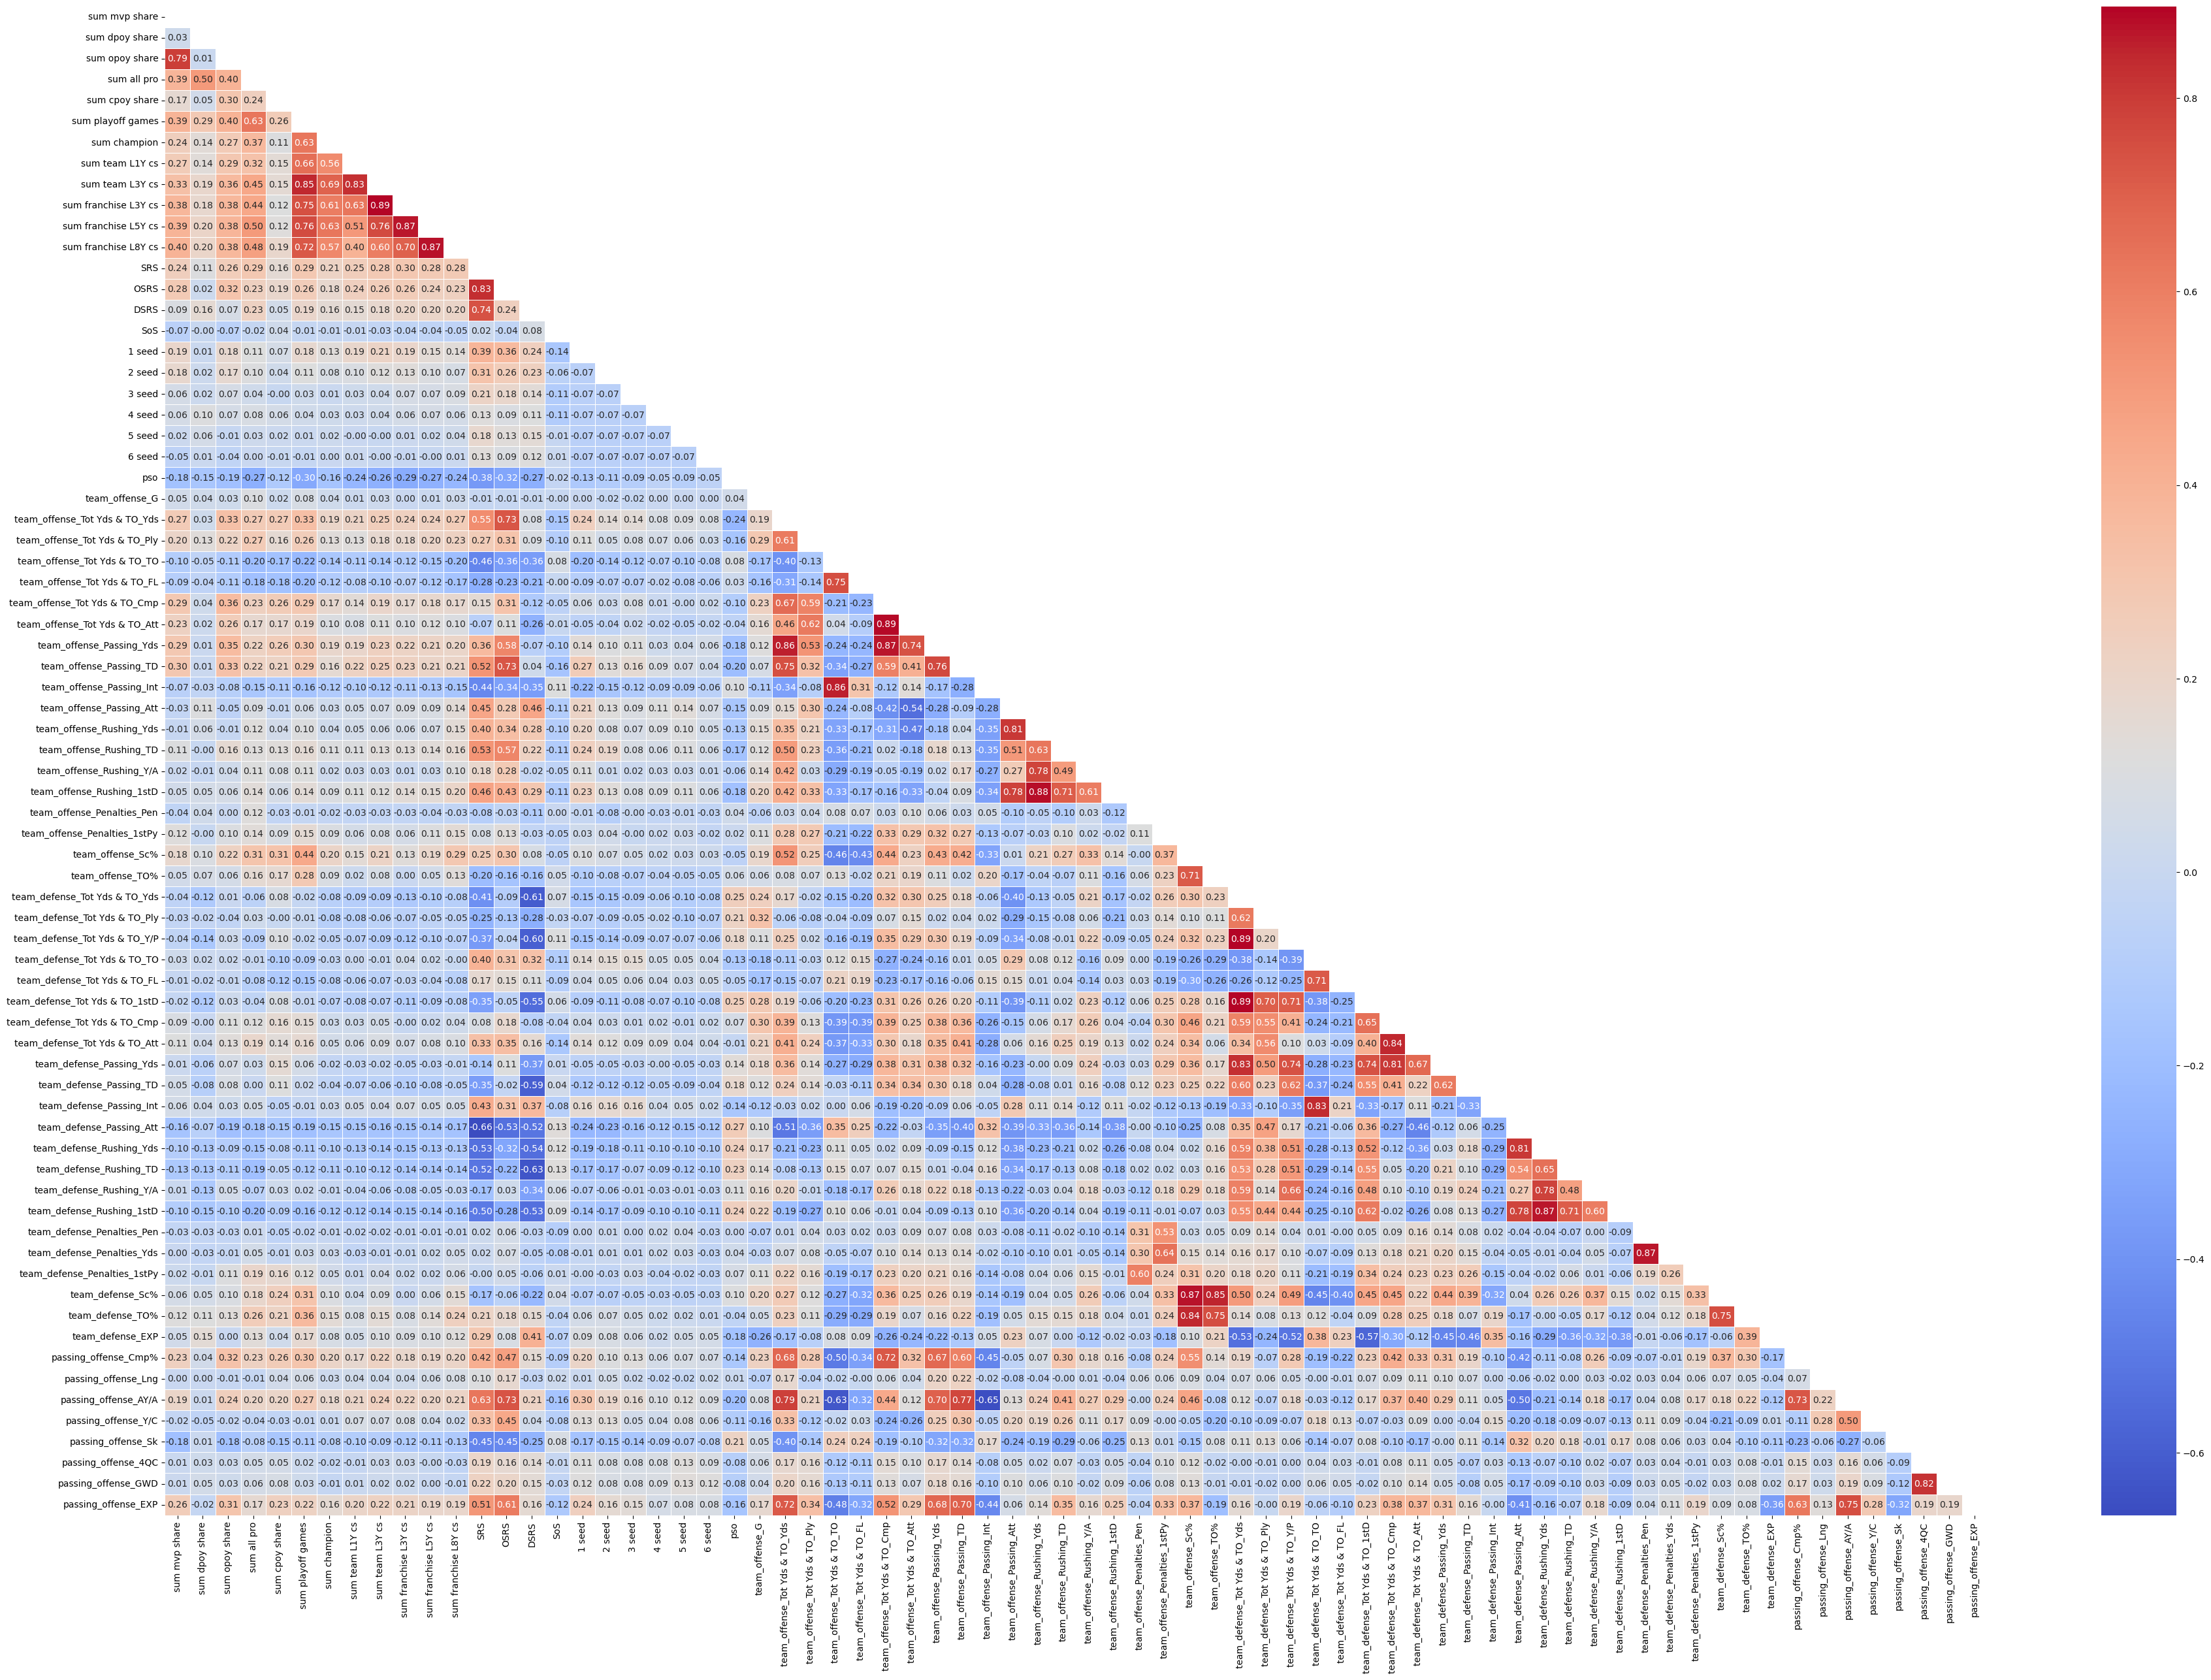

In [5]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(45, 30))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

In [14]:
train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

#model parameters
rf = RandomForestRegressor(n_estimators=14, random_state=5, min_samples_split=2, max_depth=5)
rf.fit(train[features], train["champion share"])

#predicting
predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make playoffs"] == 1]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

#error metrics
mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


#feature importance
f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


# Filter to include only playoff teams
frame_playoff = test[test["make playoffs"] == 1]

# Predicting
predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)

# Concatenate predictions to the playoff DataFrame
frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)

# Sort the DataFrame for playoff teams based on predicted champion share
frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

# Print Full Results for Playoff Teams
print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.head(6))

Error Metrics: 

PT MAE:  0.07367976387020403
PT MSE:  0.01822273147103652
PT RMSE:  0.13499159777940448
-----------------------------------------------------------------------------

Feature Importance: 

SRS                              0.409530
1 seed                           0.147338
2 seed                           0.132622
4 seed                           0.034928
DSRS                             0.026793
team_offense_Passing_Yds         0.014255
passing_offense_Lng              0.012388
3 seed                           0.012324
pso                              0.009131
OSRS                             0.009038
team_defense_Tot Yds & TO_Cmp    0.008862
passing_offense_EXP              0.008401
team_defense_Tot Yds & TO_Ply    0.007760
sum team L3Y cs                  0.007534
team_defense_Tot Yds & TO_Yds    0.007359
sum all pro                      0.006917
passing_offense_Y/C              0.006819
team_defense_Sc%                 0.006660
sum dpoy share                   0.006

In [15]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(4)
print("Ranking Accuracy (Top 4):")
print("=============================================================================\n")
print(ranking_results.to_string())

def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(4)

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Top 4: ", ap)

Ranking Accuracy (Top 4):

   Season_x                 Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023   Kansas City Chiefs              1.00                    0.715161     1      2023              1.00                    0.715161               1
1      2023  Philadelphia Eagles              0.75                    0.528388     2      2023              0.75                    0.528388               2
2      2023  San Francisco 49ers              0.50                    0.515106     3      2023              0.50                    0.515106               3
3      2023   Cincinnati Bengals              0.50                    0.152049     4      2023              0.50                    0.152049               7

PT AP Top 4:  0.8928571428571428


In [16]:
all_predictions = []
aps = []

for season in range(1991, 2024):
    if season >= 2014:  # Skip seasons before 2014
        train = df[df["Season"] < season].copy()
        test = df[df["Season"] == season].copy()

        sc = MinMaxScaler()
        sc.fit(train[features])
        train[features] = sc.transform(train[features])
        test[features] = sc.transform(test[features])

        rf.fit(train[features], train['champion share'])
        predictions = rf.predict(test[features])
        predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
        frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
        all_predictions.append(frame_playoff)
        ap = find_ap(frame_playoff)
        aps.append(ap)
        print(f"AP for Season {season}: {ap}")

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average MAE: {average_mae}")
print(f"Average MSE: {average_mse}")
print(f"Average RMSE: {average_rmse}")
print(f"Average AP: {average_ap}")
print("=============================================================================")

AP for Season 2014: 0.95
AP for Season 2015: 0.95
AP for Season 2016: 0.8041666666666667
AP for Season 2017: 0.8541666666666666
AP for Season 2018: 0.875
AP for Season 2019: 1.0
AP for Season 2020: 0.6575757575757576
AP for Season 2021: 0.8166666666666667
AP for Season 2022: 0.3566849816849817
AP for Season 2023: 0.8928571428571428

Average Error Metrics Across All Seasons:
Average MAE: 0.08395155267531787
Average MSE: 0.021959885474839576
Average RMSE: 0.14512014675866797
Average AP: 0.8157117882117882


In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, average_precision_score

target_variable = 'champion share'

train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

models = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [5, 10, 15, 100],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'random_state': [1, 5, 10, 15]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [5, 10, 15, 100],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1],
            'random_state': [1, 5, 10, 15]
        }
    },
    'NeuralNetwork': {
        'model': MLPRegressor(),
        'params': {
            'hidden_layer_sizes': [(64, 32), (32, 16)],
            'activation': ['relu'],
            'solver': ['adam'],
            'batch_size': [16, 32, 64],
            'learning_rate_init': [0.001, 0.01],
            'random_state': [1, 5, 10, 15]
        }
    }
}

from tqdm import tqdm
results = {}
for model_name, model_info in models.items():
    param_grid = ParameterGrid(model_info['params'])
    best_mae = np.inf
    best_params = None  

    for params in tqdm(param_grid, desc=f"Grid search for {model_name}", position=0, leave=True):
        if model_name == 'NeuralNetwork':
            model = MLPRegressor()
            model.set_params(**params)
            model.fit(train[features], train[target_variable])
            predictions = model.predict(test[features])
        else:
            model = model_info['model'].set_params(**params)
            model.fit(train[features], train[target_variable])
            predictions = model.predict(test[features])

        mae = mean_absolute_error(test[target_variable], predictions)

        if mae < best_mae:
            best_mae = mae
            best_params = params  

    if model_name == 'NeuralNetwork':
        final_model = MLPRegressor()
        final_model.set_params(**best_params)
        final_model.fit(train[features], train[target_variable])
    else:
        final_model = model_info['model'].set_params(**best_params)
        final_model.fit(train[features], train[target_variable])

    test['predicted champion share'] = final_model.predict(test[features])

    ap = find_ap(test)
    
    print("=============================================================================\n")
    print(f"Model: {model_name}")
    print(f"PT AP Top 4: {ap}")
    print(f"MAE: {best_mae}")
    print(f"Best Parameters: {best_params}")
    print("-----------------------------------------------------------------------------\n")

    results[model_name] = {
        'MAE': best_mae,
        'Best_Params': best_params,
        'Average_Precision_Top_4': ap
    }

    completion_percentage = (len(results) / len(models)) * 100
    print(f"Model {model_name} completed. {completion_percentage:.2f}% done.")

print("Grid search and evaluation completed.")

Grid search for RandomForest: 100%|██████████| 192/192 [02:39<00:00,  1.20it/s]



Model: RandomForest
PT AP Top 4: 0.875
MAE: 0.06847522491296185
Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 5}
-----------------------------------------------------------------------------

Model RandomForest completed. 33.33% done.


Grid search for XGBoost: 100%|██████████| 128/128 [00:05<00:00, 22.23it/s]



Model: XGBoost
PT AP Top 4: 0.8125
MAE: 0.08564617724096024
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 1}
-----------------------------------------------------------------------------

Model XGBoost completed. 66.67% done.


Grid search for NeuralNetwork: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]



Model: NeuralNetwork
PT AP Top 4: 0.7708333333333333
MAE: 0.07665389322046681
Best Parameters: {'activation': 'relu', 'batch_size': 32, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.01, 'random_state': 5, 'solver': 'adam'}
-----------------------------------------------------------------------------

Model NeuralNetwork completed. 100.00% done.
Grid search and evaluation completed.


## XGBoost Model:

In [17]:
from xgboost import XGBRegressor

train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=1)
xgb.fit(train[features], train["champion share"])

predictions = xgb.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make playoffs"] == 1]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


f_list = list(features)
f_importance = pd.Series(xgb.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


frame_playoff = test[test["make playoffs"] == 1]

predictions = xgb.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)

frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)

frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.to_string())

Error Metrics: 

PT MAE:  0.08564617724096024
PT MSE:  0.020397732102668584
PT RMSE:  0.14282062912152635
-----------------------------------------------------------------------------

Feature Importance: 

SRS                             0.164262
1 seed                          0.082962
2 seed                          0.064206
team_defense_Penalties_1stPy    0.044326
team_offense_Rushing_Y/A        0.037187
team_defense_Penalties_Yds      0.032651
team_defense_Sc%                0.022901
team_defense_Passing_TD         0.022774
4 seed                          0.022552
sum franchise L3Y cs            0.022510
team_offense_Tot Yds & TO_FL    0.021278
passing_offense_AY/A            0.019955
passing_offense_EXP             0.018840
team_offense_Passing_Yds        0.018596
sum champion                    0.018384
team_offense_Penalties_Pen      0.018010
team_defense_Rushing_Y/A        0.017606
3 seed                          0.015444
team_defense_Tot Yds & TO_FL    0.015167
OSRS          

### XGBoost Top 4 Teams Evaluation:

In [18]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(4)
print("Ranking Accuracy (Top 4):")
print("=============================================================================\n")
print(ranking_results.to_string())

def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(4)

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Top 4: ", ap)

Ranking Accuracy (Top 4):

   Season_x                 Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023   Kansas City Chiefs              1.00                    0.746889     1      2023              1.00                    0.746889               1
1      2023  Philadelphia Eagles              0.75                    0.461458     2      2023              0.75                    0.461458               4
2      2023  San Francisco 49ers              0.50                    0.617170     3      2023              0.50                    0.617170               2
3      2023   Cincinnati Bengals              0.50                    0.168294     4      2023              0.50                    0.168294               7

PT AP Top 4:  0.8303571428571428


In [19]:
all_predictions = []
aps = []

for season in range(1991, 2024):
    if season >= 2014:  # Skip seasons before 2014
        train = df[df["Season"] < season].copy()
        test = df[df["Season"] == season].copy()

        sc = MinMaxScaler()
        sc.fit(train[features])
        train[features] = sc.transform(train[features])
        test[features] = sc.transform(test[features])

        xgb.fit(train[features], train['champion share'])
        predictions = xgb.predict(test[features])
        predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
        frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
        all_predictions.append(frame_playoff)
        ap = find_ap(frame_playoff)
        aps.append(ap)
        print(f"AP for Season {season}: {ap}")

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average MAE: {average_mae}")
print(f"Average MSE: {average_mse}")
print(f"Average RMSE: {average_rmse}")
print(f"Average AP: {average_ap}")
print("=============================================================================")

AP for Season 2014: 0.7708333333333333
AP for Season 2015: 0.7708333333333333
AP for Season 2016: 0.8541666666666666
AP for Season 2017: 0.8928571428571428
AP for Season 2018: 0.9166666666666666
AP for Season 2019: 1.0
AP for Season 2020: 0.48333333333333334
AP for Season 2021: 0.8875
AP for Season 2022: 0.43465909090909094
AP for Season 2023: 0.8125

Average Error Metrics Across All Seasons:
Average MAE: 0.08450445914868396
Average MSE: 0.02283016956517791
Average RMSE: 0.14896833266651124
Average AP: 0.7823349567099567


### XGBoost Champion Evaluation:

In [20]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(1) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

                 Team  champion share_x  predicted champion share_x  Rank  champion share_y  predicted champion share_y  Predicted Rank
0  Kansas City Chiefs               1.0                    0.746889     1               1.0                    0.746889               1

PT AP Champion:  1.0


In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


all_predictions = []
aps = []

backtest_seasons = [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season', 'make playoffs'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    xgb.fit(train[features], train['champion share'])
    predictions = xgb.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season", "make playoffs"]], predictions_df], axis=1)

    # Save predictions for the current season to the combined DataFrame
    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(5)
    
    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted champion share", "champion share"]])

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Champion AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Champion AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Champion AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

Champion AP for Season 2014: 1.0 | Reciprocal: 1.0
Champion AP for Season 2015: 1.0 | Reciprocal: 1.0
Champion AP for Season 2016: 0.25 | Reciprocal: 4.0
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0
Champion AP for Season 2018: 0.5 | Reciprocal: 2.0
Champion AP for Season 2019: 0.25 | Reciprocal: 4.0
Champion AP for Season 2020: 0.5 | Reciprocal: 2.0
Champion AP for Season 2021: 0.2 | Reciprocal: 5.0
Champion AP for Season 2022: 0.25 | Reciprocal: 4.0
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0

Top 5 Predicted Teams for Season 2014:
                    Team  predicted champion share  champion share
288     Seattle Seahawks                  0.754471            1.00
292    Carolina Panthers                  0.617946            0.25
289       Denver Broncos                  0.518749            0.75
291  San Francisco 49ers                  0.415965            0.50
305    Green Bay Packers                  0.328532            0.00

Top 5 Predicted Teams for Season 2015:
     

## RandomForest Model:

In [87]:
train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

rf = RandomForestRegressor(n_estimators=100, random_state=5, min_samples_split=5, max_depth=5)
rf.fit(train[features], train["champion share"])

predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make playoffs"] == 1]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


frame_playoff = test[test["make playoffs"] == 1]

predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)

frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)

frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.to_string())

Error Metrics: 

PT MAE:  0.06847522491296183
PT MSE:  0.016112052236066897
PT RMSE:  0.12693325898308488
-----------------------------------------------------------------------------

Feature Importance: 

SRS                              0.408255
1 seed                           0.154107
2 seed                           0.139567
4 seed                           0.028393
passing_offense_EXP              0.013992
team_offense_Passing_Yds         0.013801
passing_offense_Lng              0.013740
3 seed                           0.012780
team_defense_EXP                 0.011245
DSRS                             0.010410
OSRS                             0.007989
team_offense_Sc%                 0.007919
team_defense_Tot Yds & TO_Yds    0.007573
team_defense_Passing_Att         0.007210
sum all pro                      0.007001
pso                              0.006336
sum franchise L3Y cs             0.005847
passing_offense_Y/C              0.005787
team_defense_Penalties_Pen       0.00

### RandomForest Top 4 Teams Evaluation:

In [88]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(4) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(4) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x                 Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023   Kansas City Chiefs              1.00                    0.664683     1      2023              1.00                    0.664683               1
1      2023  Philadelphia Eagles              0.75                    0.568776     2      2023              0.75                    0.568776               2
2      2023  San Francisco 49ers              0.50                    0.537687     3      2023              0.50                    0.537687               3
3      2023   Cincinnati Bengals              0.50                    0.149399     4      2023              0.50                    0.149399               8

PT AP Champion:  0.875


In [89]:
all_predictions = []
aps = []

for season in range(1991, 2024):
    if season >= 2014:  # Skip seasons before 2014
        train = df[df["Season"] < season].copy()
        test = df[df["Season"] == season].copy()

        sc = MinMaxScaler()
        sc.fit(train[features])
        train[features] = sc.transform(train[features])
        test[features] = sc.transform(test[features])

        rf.fit(train[features], train['champion share'])
        predictions = rf.predict(test[features])
        predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
        frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
        all_predictions.append(frame_playoff)
        ap = find_ap(frame_playoff)
        aps.append(ap)
        print(f"AP for Season {season}: {ap}")

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average MAE: {average_mae}")
print(f"Average MSE: {average_mse}")
print(f"Average RMSE: {average_rmse}")
print(f"Average AP: {average_ap}")
print("=============================================================================")

AP for Season 2014: 0.8875
AP for Season 2015: 0.8875
AP for Season 2016: 0.95
AP for Season 2017: 0.8303571428571428
AP for Season 2018: 0.875
AP for Season 2019: 1.0
AP for Season 2020: 0.5560897435897436
AP for Season 2021: 0.8303571428571428
AP for Season 2022: 0.3566849816849817
AP for Season 2023: 0.875

Average Error Metrics Across All Seasons:
Average MAE: 0.08371228803729679
Average MSE: 0.022798846083605263
Average RMSE: 0.1482356503819554
Average AP: 0.8048489010989011


### RandomForest Champion Evaluation:

In [90]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(1) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

                 Team  champion share_x  predicted champion share_x  Rank  champion share_y  predicted champion share_y  Predicted Rank
0  Kansas City Chiefs               1.0                    0.664683     1               1.0                    0.664683               1

PT AP Champion:  1.0


In [91]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

all_predictions = []
aps = []

backtest_seasons = [2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)

    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(5)
    
    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted champion share", "champion share"]])

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Champion AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Champion AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Champion AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

Champion AP for Season 2014: 1.0 | Reciprocal: 1.0
Champion AP for Season 2015: 0.5 | Reciprocal: 2.0
Champion AP for Season 2016: 1.0 | Reciprocal: 1.0
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0
Champion AP for Season 2018: 0.33 | Reciprocal: 3.0
Champion AP for Season 2019: 0.25 | Reciprocal: 4.0
Champion AP for Season 2020: 0.25 | Reciprocal: 4.0
Champion AP for Season 2021: 0.14 | Reciprocal: 7.0
Champion AP for Season 2022: 0.14 | Reciprocal: 7.0
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0

Top 5 Predicted Teams for Season 2014:
                     Team  predicted champion share  champion share
288      Seattle Seahawks                  0.580123            1.00
289        Denver Broncos                  0.530556            0.75
292     Carolina Panthers                  0.510872            0.25
291   San Francisco 49ers                  0.432975            0.50
290  New England Patriots                  0.425935            0.50

Top 5 Predicted Teams for Season 201

## Best Model:

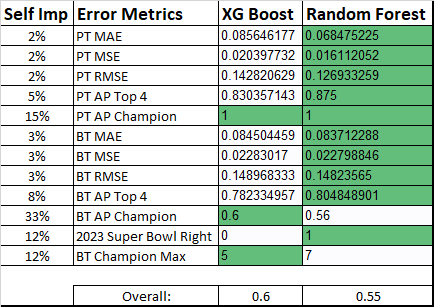

- Both of the Models have their advantages over each other.

In [39]:
combined_predictions.to_csv('L10S Preds XG.csv', index=False)

Top Features:
['SRS', '2 seed', '1 seed', '4 seed', 'passing_offense_AY/A', 'team_defense_Rushing_Yds', 'passing_offense_EXP', 'OSRS', '6 seed', 'pso', 'passing_offense_4QC', '3 seed', 'team_offense_Passing_Yds', 'team_defense_Sc%', 'team_offense_Rushing_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Sc%', 'SoS', 'team_offense_Tot Yds & TO_Yds', 'team_defense_EXP', 'team_defense_Rushing_Y/A', 'sum all pro', 'passing_offense_Y/C', 'sum cpoy share', 'DSRS', 'team_offense_Rushing_TD', 'team_defense_Passing_TD', 'team_offense_G', 'team_defense_Tot Yds & TO_Ply', 'sum mvp share', 'team_offense_Rushing_Y/A', 'sum franchise L3Y cs', 'sum playoff games', 'passing_offense_Lng', 'team_offense_Passing_Att', 'team_offense_Tot Yds & TO_Att', 'team_defense_TO%', 'team_offense_Tot Yds & TO_FL', 'team_defense_Passing_Yds', 'sum dpoy share', 'team_defense_Penalties_Pen', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Att', '5 seed', 'team_defense_Tot Yds & TO_Y/P', 'sum team L3Y cs', 'sum

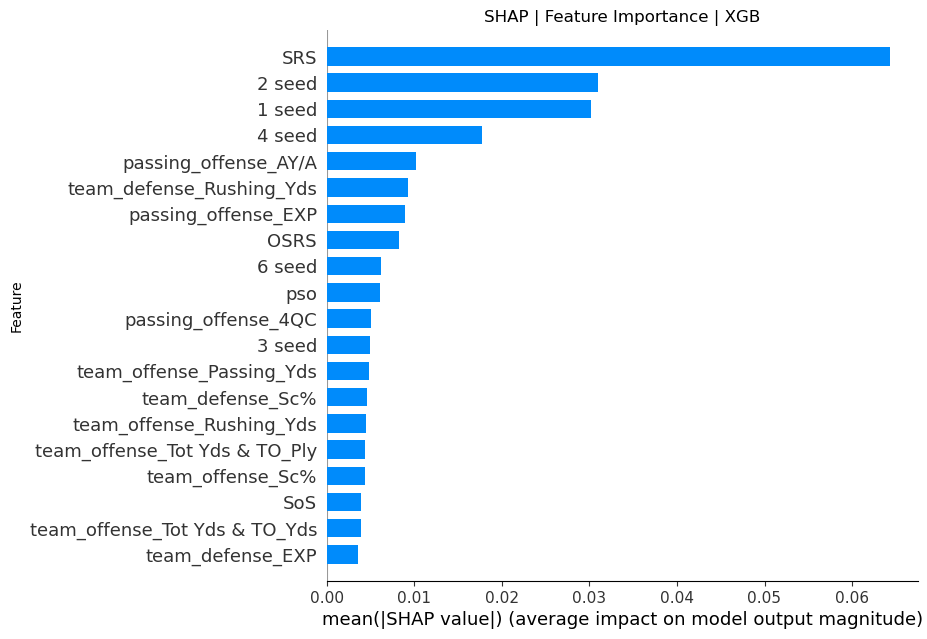

In [33]:
import shap
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(test[features])

shap.summary_plot(shap_values, test[features], feature_names=features, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Feature Importance | XGB')
plt.savefig("xg_shap_bar.png", bbox_inches='tight', pad_inches=0.1)

image = Image.open("xg_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("xg_shap_bar.png")

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1]

top_features_list = [features[index] for index in top_features]
print("Top Features:")
print(top_features_list)

plt.ylabel("Feature")
plt.show()

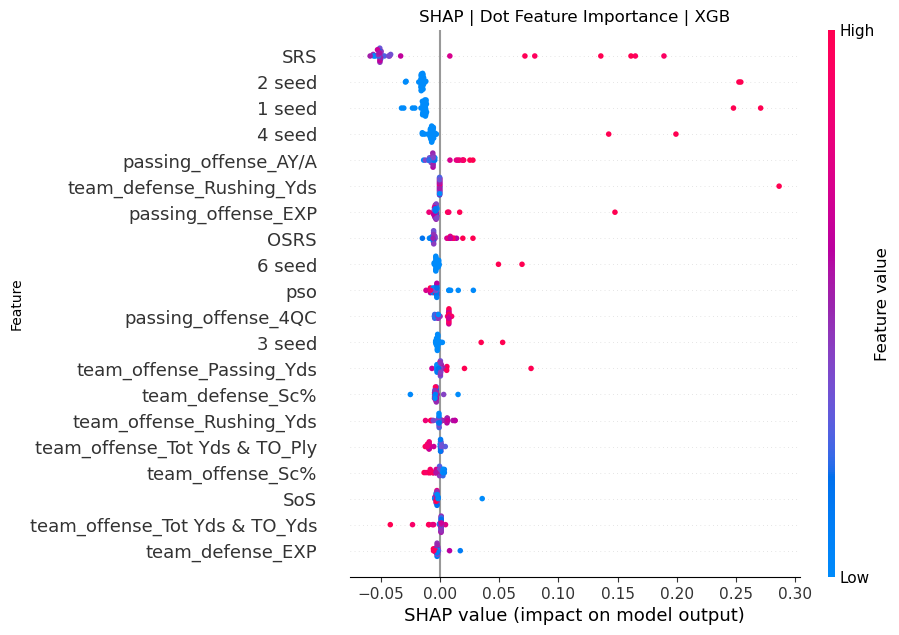

In [97]:
explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(test[features])
shap.summary_plot(shap_values, test[features], feature_names=features, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | XGB')

plt.savefig("xg_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("xg_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("xg_shap_dot.png")

plt.ylabel("Feature")
plt.show()